<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#8484ff;
       font-size:110%;
       font-family:Verdana;
       letter-spacing:0.5px">
    <p style="padding: 10px;
          color:white;">
<h1 style="font-family:verdana;"> <center>📊 OTTO EDA Notebook 📊</center> </h1>
    <\p>
        <\div>

# 📝About data📝
- **Training data structure**
    - **session** - the unique id of session
    - **events** - ordered events, that happened in this session. Each event consists of:
        - **aid**
            - the article id (product code) of the associated event
        - **ts**
            - the Unix timestamp of the event (in microseconds)
        - **type**
            - the event type ("clicks", "carts", "orders").
            - Whether a product was clicked, added to the user's cart, or ordered during the session
- **Prediction**
    - **Session type** - "{session id}_{type}" like 12899779_clicks
    - **labels** - predicted first 20 aids corresponding to session type

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Read data

In [2]:
data_root_path = Path('../input/otto-recommender-system')

chunksize = 5000
train_data = pd.read_json(data_root_path / 'train.jsonl', lines=True, chunksize=chunksize)
test_data = pd.read_json(data_root_path / 'test.jsonl', lines=True, chunksize=chunksize)
sample_submission = pd.read_csv(data_root_path / 'sample_submission.csv', chunksize=chunksize)

In [3]:
test_data.__next__()

,session,events
0,12899779,"[{'aid': 59625, 'ts': 1661724000278, 'type': '..."
1,12899780,"[{'aid': 1142000, 'ts': 1661724000378, 'type':..."
2,12899781,"[{'aid': 141736, 'ts': 1661724000559, 'type': ..."
3,12899782,"[{'aid': 1669402, 'ts': 1661724000568, 'type':..."
4,12899783,"[{'aid': 255297, 'ts': 1661724000572, 'type': ..."
...,...,...
4995,12904774,"[{'aid': 585834, 'ts': 1661726705968, 'type': ..."
4996,12904775,"[{'aid': 1794666, 'ts': 1661726706068, 'type':..."
4997,12904776,"[{'aid': 247240, 'ts': 1661726709654, 'type': ..."
4998,12904777,"[{'aid': 917587, 'ts': 1661726710443, 'type': ..."


In [4]:
sample_submission.__next__()

,session_type,labels
0,12899779_clicks,129004 126836 118524
1,12899779_carts,129004 126836 118524
2,12899779_orders,129004 126836 118524
3,12899780_clicks,129004 126836 118524
4,12899780_carts,129004 126836 118524
...,...,...
4995,12901444_clicks,129004 126836 118524
4996,12901444_carts,129004 126836 118524
4997,12901444_orders,129004 126836 118524
4998,12901445_clicks,129004 126836 118524


In [5]:
# NOTE: comment out to save processing time
# with open(data_root_path / 'train.jsonl', 'r') as f:
#     nb_train_records = len(f.readlines())
#     print(f"Train: {nb_train_records} lines")
# with open(data_root_path / 'test.jsonl', 'r') as f:
#     nb_test_records = len(f.readlines())
#     print(f"Test: {nb_test_records} lines")

nb_train_records = 12899779
nb_test_records = 1671803
print(f"Train: {nb_train_records} lines")
print(f"Test: {nb_test_records} lines")

Train: 12899779 lines
Test: 1671803 lines


## Random read

In [6]:
nb_chosen_chunk = 2
indices = np.arange(50)
sample_chunk_id = random.sample(list(indices), nb_chosen_chunk)
chunks_of_train = []

# limit times of reading to save processing time
for idx in range(max(sample_chunk_id)+1):
    chunk = train_data.__next__()
    if idx in sample_chunk_id:
        chunks_of_train.append(chunk)

df_train_chunk = pd.concat(chunks_of_train)
df_train_chunk

,session,events
35000,35000,"[{'aid': 1432550, 'ts': 1659307159271, 'type':..."
35001,35001,"[{'aid': 1560850, 'ts': 1659307159326, 'type':..."
35002,35002,"[{'aid': 618373, 'ts': 1659307159455, 'type': ..."
35003,35003,"[{'aid': 614407, 'ts': 1659307159975, 'type': ..."
35004,35004,"[{'aid': 806769, 'ts': 1659307160086, 'type': ..."
...,...,...
224995,224995,"[{'aid': 521711, 'ts': 1659337864317, 'type': ..."
224996,224996,"[{'aid': 39846, 'ts': 1659337864346, 'type': '..."
224997,224997,"[{'aid': 1624406, 'ts': 1659337864384, 'type':..."
224998,224998,"[{'aid': 647659, 'ts': 1659337864387, 'type': ..."


In [7]:
events_dict = {
    "session": [],
    "aid": [],
    "ts": [],
    "type": [],
}

for _, row in df_train_chunk.iterrows():
    for event in row["events"]:
        events_dict["session"].append(row["session"])
        events_dict["aid"].append(event["aid"])
        events_dict["ts"].append(event["ts"])
        events_dict["type"].append(event["type"])

df_train_part = pd.DataFrame(events_dict)
df_train_part

,session,aid,ts,type
0,35000,1432550,1659307159271,clicks
1,35000,1432550,1659307585243,carts
2,35000,1363791,1659307626231,clicks
3,35000,1432550,1659307648922,clicks
4,35000,141795,1659307836990,clicks
...,...,...,...,...
473119,224999,1508870,1659777326577,orders
473120,224999,1508870,1659824915996,clicks
473121,224999,1508870,1660038505061,clicks
473122,224999,294319,1660914484811,clicks


# 📈Visualization📉

## Type counts

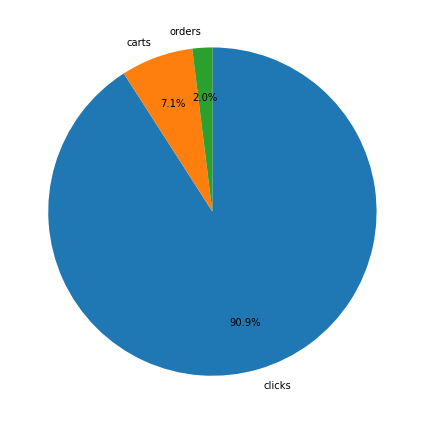

In [8]:
type_counts = df_train_part['type'].value_counts()
label = list(type_counts.index)

plt.figure(figsize=(6, 6))
plt.pie(type_counts,
        labels=label, counterclock=False, startangle=90,
        autopct='%1.1f%%', pctdistance=0.7)
plt.tight_layout()
plt.show()

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#fff4ea;
       font-size:110%;
       font-family:Verdana;
       letter-spacing:0.5px">
    <p style="padding: 10px;
          color:black;">
        📒High percentage of clicks<br>
        📒clicksの割合が大きい。
    </p>
</div>

## Session length

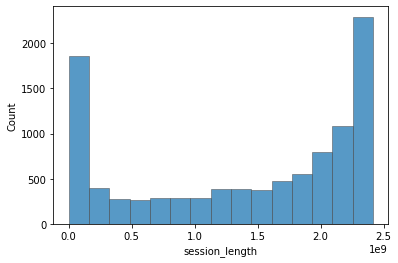

In [9]:
ts_max_min = df_train_part.groupby('session').agg([max, min])['ts']
ts_max_min['session_length'] = ts_max_min['max'] - ts_max_min['min']

sns.histplot(
    ts_max_min,
    x="session_length",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
)
plt.show()

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#fff4ea;
       font-size:110%;
       font-family:Verdana;
       letter-spacing:0.5px">
    <p style="padding: 10px;
          color:black;">
        📒The degree of bin with short session time is large. Most leave the page immediately?<br>
        📒session時間が短いbinの度数が大きい。ほとんどはすぐにページから離脱してしまう？
    </p>
</div>

## Percentage of type per Session hour

In [10]:
df_counts_type = df_train_part.groupby(['session', 'type']).size()
df_counts_type = pd.DataFrame(df_counts_type).reset_index(level=1)
df_counts_type = df_counts_type.rename(columns={0: 'counts'})
df_counts_type = df_counts_type.pivot_table(['counts'], index='session', columns='type')
df_counts_type = df_counts_type['counts'].fillna(0)

new_columns = {col: f'{col}_counts' for col in df_counts_type.columns}
df_counts_type = df_counts_type.rename(columns=new_columns)
df_counts_type = pd.concat([df_counts_type, ts_max_min['session_length']], axis=1)

# add type dummy
df_counts_type['order_dummy'] = df_counts_type['orders_counts'] > 0
df_counts_type['carts_dummy'] = df_counts_type['carts_counts'] > 0
df_counts_type['click_only'] = (df_counts_type['order_dummy'] == False) & (df_counts_type['carts_dummy'] == False)
df_counts_type['carts_not_order'] = (df_counts_type['order_dummy'] == False) & (df_counts_type['carts_dummy'] == True)

series = df_counts_type['order_dummy'] == True
ordered_index = series[series].index

series = df_counts_type['click_only'] == True
click_only_index = series[series].index

series = df_counts_type['carts_not_order'] == True
carts_not_order_index = series[series].index

df_counts_type['event'] = ''
df_counts_type['event'][ordered_index] = 'ordered'
df_counts_type['event'][click_only_index] = 'click_only'
df_counts_type['event'][carts_not_order_index] = 'carts_not_order'
df_counts_type

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,carts_counts,clicks_counts,orders_counts,session_length,order_dummy,carts_dummy,click_only,carts_not_order,event
session,,,,,,,,,
35000,2.0,14.0,0.0,2146112104,False,True,False,True,carts_not_order
35001,0.0,10.0,0.0,330082813,False,False,True,False,click_only
35002,2.0,4.0,0.0,202962703,False,True,False,True,carts_not_order
35003,7.0,14.0,0.0,2070048375,False,True,False,True,carts_not_order
35004,8.0,41.0,0.0,2334028205,False,True,False,True,carts_not_order
...,...,...,...,...,...,...,...,...,...
224995,3.0,23.0,3.0,2369296569,True,True,False,False,ordered
224996,0.0,34.0,0.0,2237737066,False,False,True,False,click_only
224997,0.0,5.0,0.0,2169448824,False,False,True,False,click_only


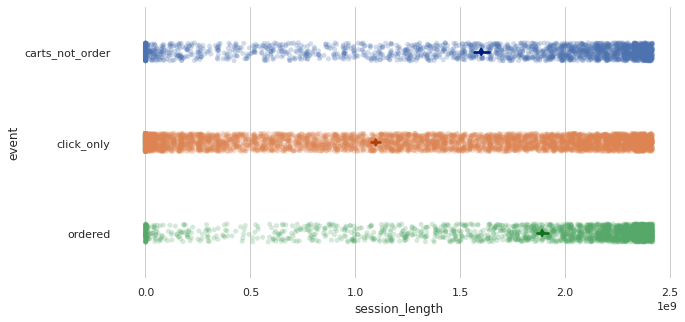

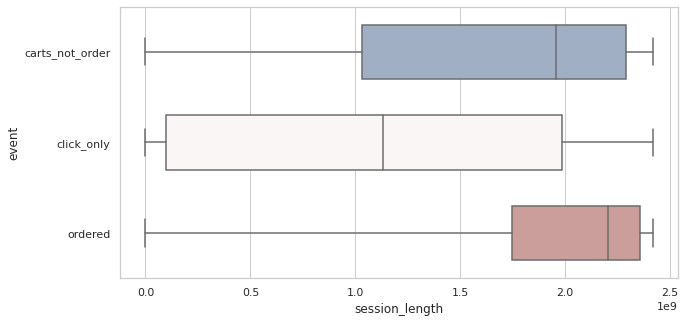

In [11]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(bottom=True, left=True)

sns.stripplot(
    data=df_counts_type, x="session_length", y="event",
    dodge=True, alpha=.25, zorder=1
)

sns.pointplot(
    data=df_counts_type, x="session_length", y="event",
    join=False, dodge=.8 - .8 / 3, palette="dark",
    markers="d", scale=.75, errorbar=None
)
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_counts_type, x="session_length", y="event",
            whis=[0, 100], width=.6, palette="vlag")
plt.show()

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#fff4ea;
       font-size:110%;
       font-family:Verdana;
       letter-spacing:0.5px">
    <p style="padding: 10px;
          color:black;">
        📒Click-only sessions include both short and long sessions.<br>
          Sessions with carts w/o order and with order tend to be long.
        <br>
        📒clickのみのsessionは短時間も長時間も含む。<br>
          orderがないcarts、orderがあるsessionは時間が長い傾向にある。
    </p>
</div>

In [12]:
session_time = {
    '0~10min': (0, 600*1e6),
    '10~20min': (600*1e6, 1200*1e6),
    '20~30min': (1200*1e6, 1800*1e6),
    '30~40min': (1800*1e6, 2400*1e6),
    '40~50min': (2400*1e6, 3000*1e6),
    '50~60min': (3000*1e6, 3600*1e6),
    '60~min': (3600*1e6, -1),
    }

df_session_times = []

for name, session_range in session_time.items():
    session_min, session_max = session_range
    
    if session_max == -1:
        df = df_counts_type[
            df_counts_type['session_length'] > session_min]
    else:
        df = df_counts_type[
            (df_counts_type['session_length'] > session_min) & \
            (df_counts_type['session_length'] < session_max)]
    
    df = pd.DataFrame(df[['carts_counts', 'clicks_counts', 'orders_counts']].sum())
    df = df.rename(columns={0: name})
    df_session_times.append(df)
    
df_session_times = pd.concat(df_session_times, axis=1)
df_session_times

,0~10min,10~20min,20~30min,30~40min,40~50min,50~60min,60~min
carts_counts,1805.0,1560.0,3250.0,23905.0,3147.0,0.0,0.0
clicks_counts,23496.0,20257.0,46540.0,299394.0,40484.0,0.0,0.0
orders_counts,398.0,489.0,964.0,6603.0,832.0,0.0,0.0


In [13]:
df_session_times = df_session_times / df_session_times.sum()
df_session_times = df_session_times.fillna(0)

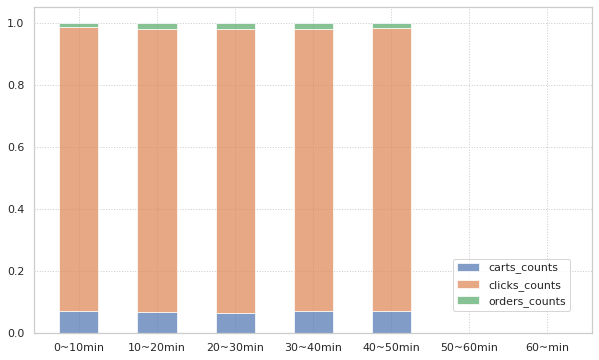

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(df_session_times)):
    ax.bar(df_session_times.columns,
           df_session_times.iloc[i],
           bottom=df_session_times.iloc[:i].sum(),
           width=.5,
           alpha=.7)

ax.legend(df_session_times.index.tolist(), loc='lower right', borderaxespad=2)
plt.grid(linestyle='dotted', linewidth=1)
plt.show()

## Feature of sessions including "carts" or "orders"

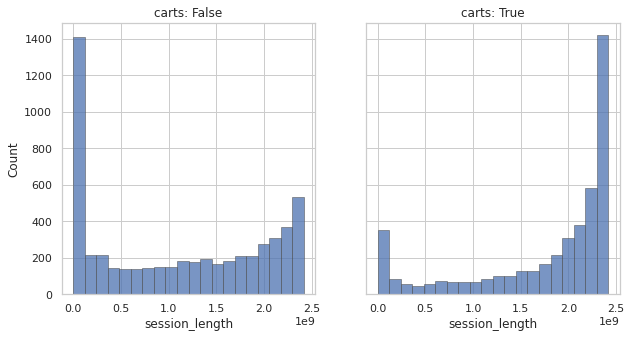

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='all')

axes[0].set_title('carts: False')
sns.histplot(
    df_counts_type[df_counts_type['carts_dummy'] == False],
    x="session_length",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[0],
    bins=20
)

axes[1].set_title('carts: True')
sns.histplot(
    df_counts_type[df_counts_type['carts_dummy'] == True],
    x="session_length",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[1],
    bins=20
)
plt.show()

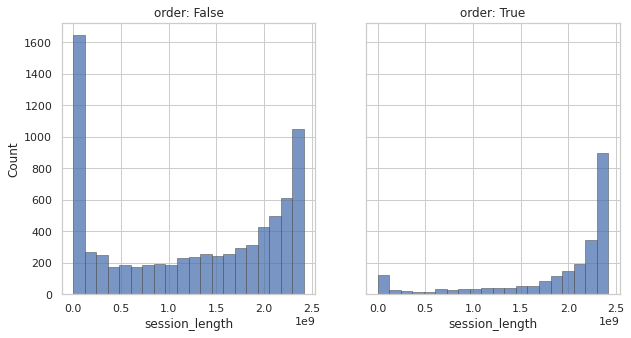

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='all')

axes[0].set_title('order: False')
sns.histplot(
    df_counts_type[df_counts_type['order_dummy'] == False],
    x="session_length",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[0],
    bins=20
)

axes[1].set_title('order: True')
sns.histplot(
    df_counts_type[df_counts_type['order_dummy'] == True],
    x="session_length",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    ax=axes[1],
    bins=20
)
plt.show()

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#fff4ea;
       font-size:110%;
       font-family:Verdana;
       letter-spacing:0.5px">
    <p style="padding: 10px;
          color:black;">
        📒the session in which carts or order was made has fewer bin with shorter session time.<br>
        📒carts, orderが行われたsessionはsession時間が短いbinが少ない。
    </p>
</div>

## Top N items

In [17]:
df_aid = pd.DataFrame(df_train_part.groupby(['aid']).size()).sort_values(by=0, ascending=False)
df_aid = df_aid.rename(columns={0: 'counts'})
print(f'unique aid: {len(df_aid)}')

thres_counts = 100
df_thres_counts = df_aid[df_aid["counts"] > thres_counts]
print(f'aid counts > {thres_counts}: {len(df_thres_counts)}')

unique aid: 151573
aid counts > 100: 80


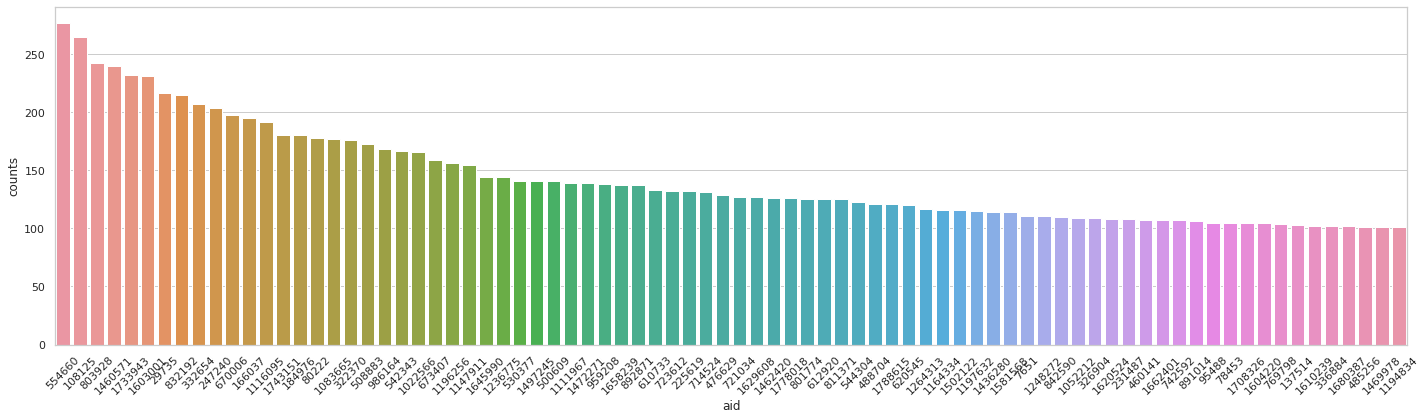

In [18]:
df = df_thres_counts.reset_index()
fig = plt.figure(figsize=(20, 6))
sns.barplot(x='aid', y='counts', data=df, order=df.sort_values('counts', ascending=False).aid)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Features between items

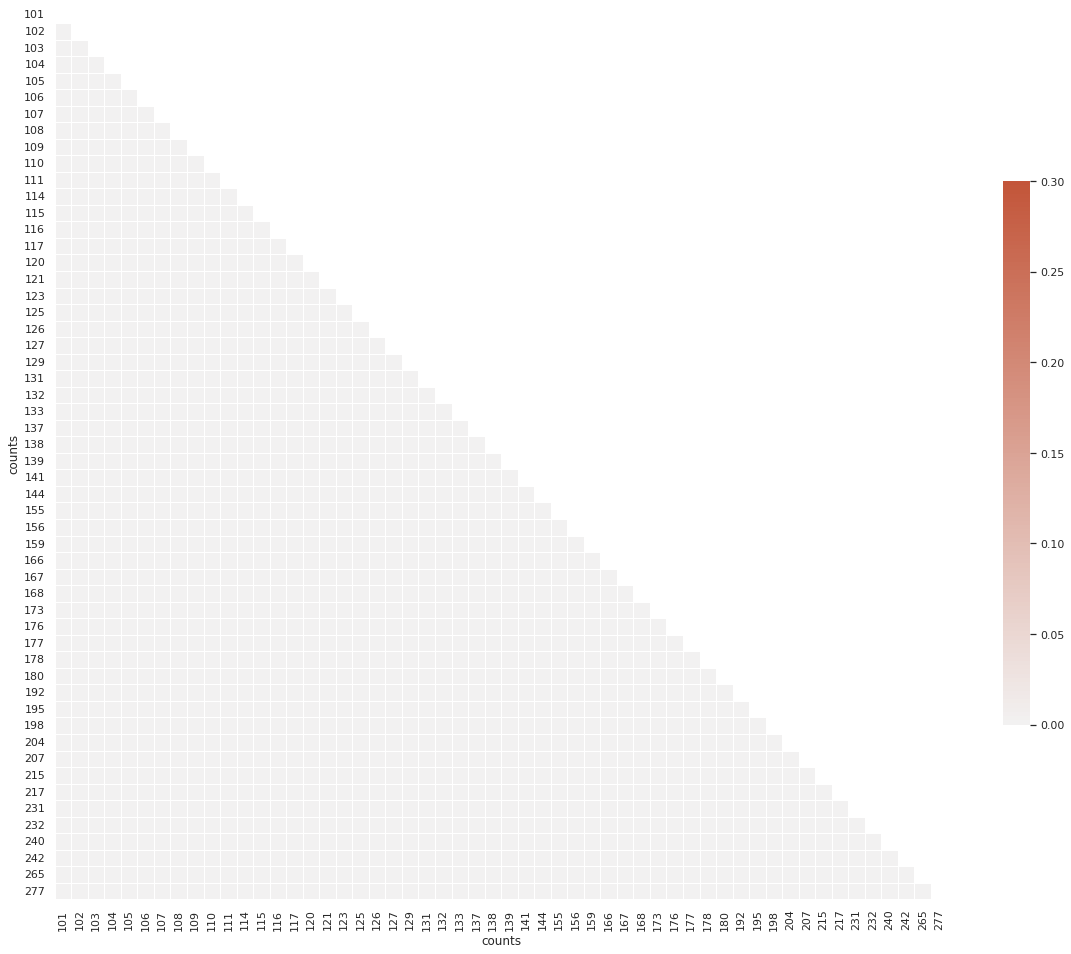

In [19]:
fig = plt.figure(figsize=(20,20))
aid_cross = pd.crosstab(df_thres_counts['counts'], df_thres_counts['counts'])
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(aid_cross, dtype=bool))
sns.heatmap(aid_cross, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

<div style="color:white;
       display:fill;
       border-radius:5px;
       background-color:#fff4ea;
       font-size:110%;
       font-family:Verdana;
       letter-spacing:0.5px">
    <p style="padding: 10px;
          color:black;">
        📒Is there any tendency that when an action is taken on one item, another item is also acted on as a set?<br>
        📒あるitemに対してactionしたら別のitemもセットでactionが起こされるという傾向は見られない？
    </p>
</div>

## Features of items per session

In [20]:
df_type_aid = df_train_part.groupby(['session', 'type', 'aid']).size()
df_type_aid = pd.DataFrame(df_type_aid).reset_index(level=[1, 2])
df_type_aid = df_type_aid.rename(columns={0: 'counts'})
df_type_aid.head(5)

,type,aid,counts
session,,,
35000,carts,273918,1
35000,carts,1432550,1
35000,clicks,22456,1
35000,clicks,111013,1
35000,clicks,141795,1


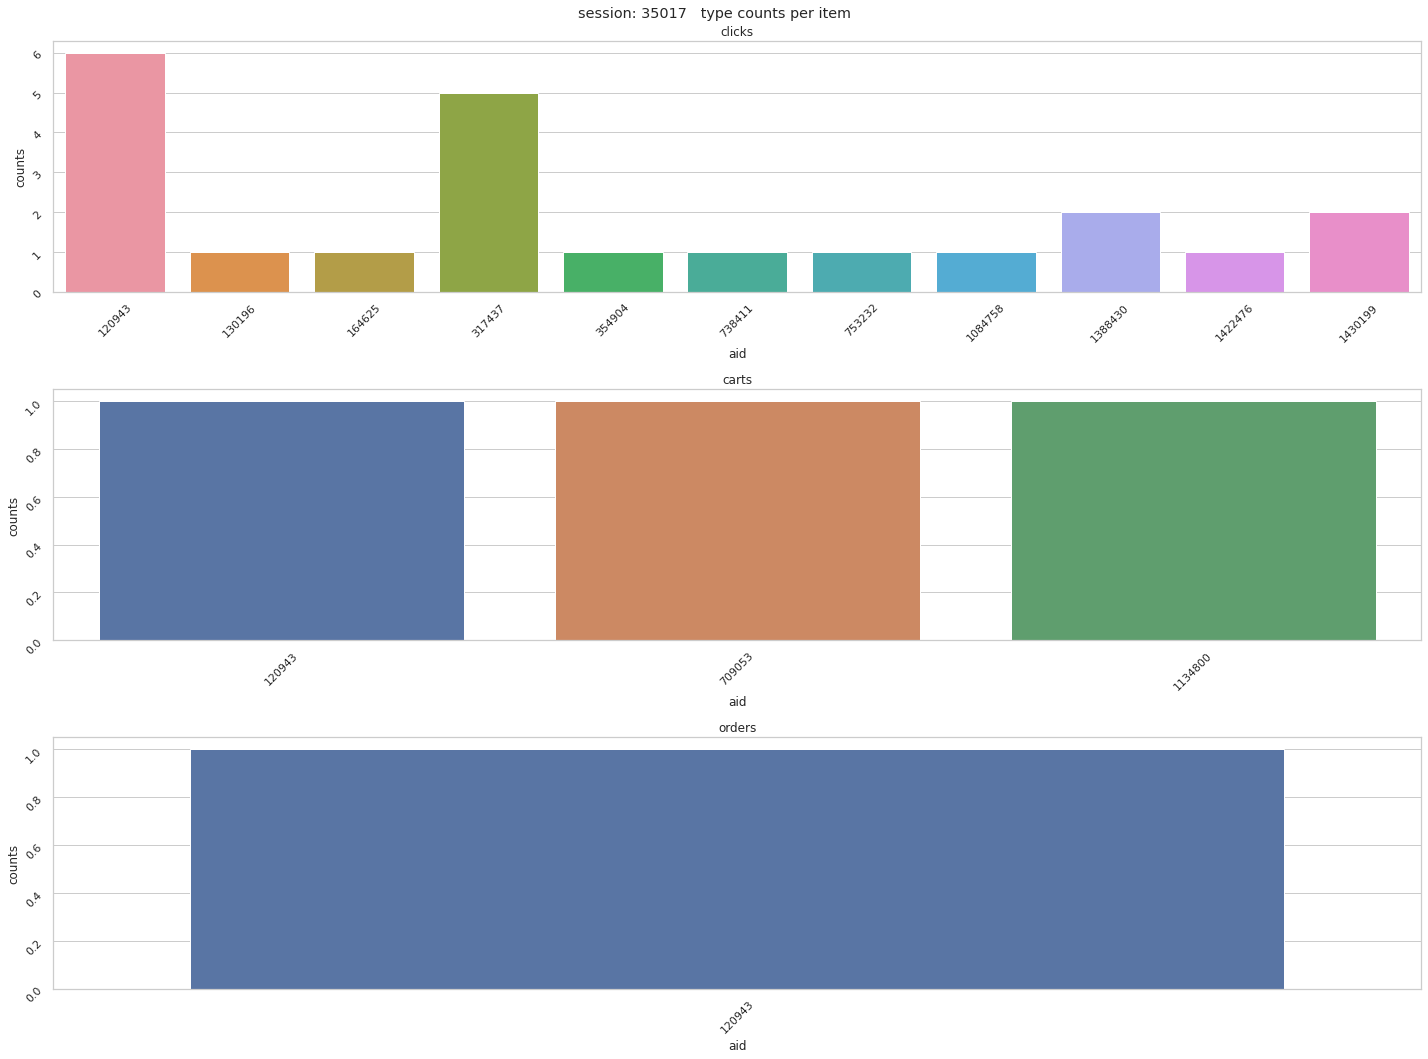

In [34]:
target_session_id = df_type_aid[df_type_aid['type']=='orders'].index[0] # select session including 'order'

fig, axes = plt.subplots(3, 1, figsize=(20, 15))
fig.suptitle(f'session: {target_session_id}   type counts per item')
df = df_type_aid[df_type_aid.index == target_session_id]

for i, type_name in enumerate(['clicks', 'carts', 'orders']):
    sns.barplot(x="aid", y="counts", data=df[df['type'] == type_name], ax=axes[i])
    axes[i].tick_params(labelrotation=45)
    axes[i].set_title(type_name)

plt.tight_layout()
plt.show()

# References
- https://www.kaggle.com/code/mohdmuttalib/otto-eda